In [2]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]

from utilities import get_tex_label, get_color, latex_text_width_1col
from hazma.parameters import vh
from hazma.gamma_ray_parameters import (energy_res_comptel, energy_res_fermi,
                                        energy_res_e_astrogam, energy_res_egret)
from hazma.scalar_mediator import ScalarMediator, HiggsPortal, HeavyQuark
from hazma.vector_mediator import VectorMediator

## Investigations

### Region where $\sigma_{\bar{\chi}\chi\to \pi \pi} \to 0$

(1e-05, 0.01)

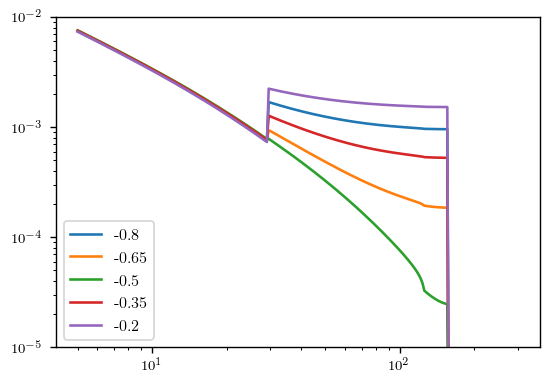

In [16]:
for gsGG in np.linspace(-0.8, -0.2, 5):
    sm = ScalarMediator(185., 1e3, 1., 1., gsGG, 0., 246e3)
    e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw**2)

    plt.loglog(e_gams, sm.spectra(e_gams, e_cm)["total"], label=gsGG)

plt.legend()
plt.ylim(1e-5, 1e-2)

(1e-05, 0.01)

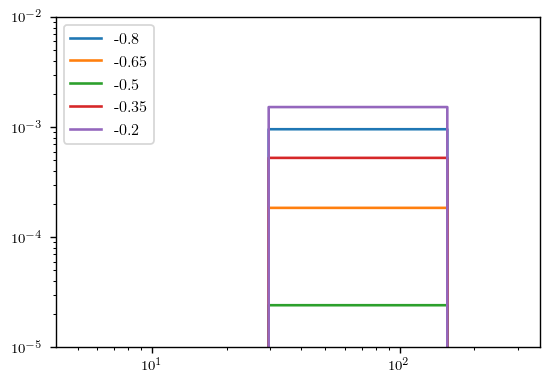

In [19]:
for gsGG in np.linspace(-0.8, -0.2, 5):
    sm = ScalarMediator(185., 1e3, 1., 1., gsGG, 0., 246e3)
    e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw**2)

    plt.loglog(e_gams, sm.spectra(e_gams, e_cm)["pi0 pi0"], label=gsGG)

plt.legend()
plt.ylim(1e-5, 1e-2)

(1e-05, 0.01)

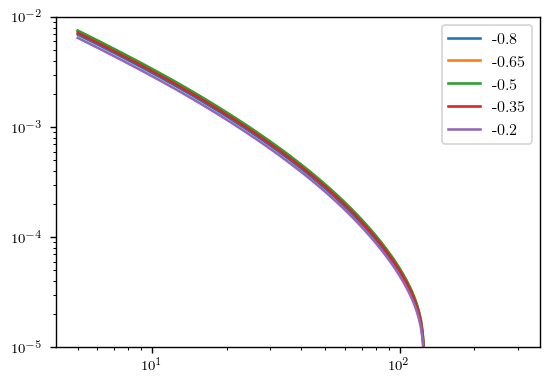

In [15]:
for gsGG in np.linspace(-0.8, -0.2, 5):
    sm = ScalarMediator(185., 1e3, 1., 1., gsGG, 0., 246e3)
    e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw**2)

    plt.loglog(e_gams, sm.spectra(e_gams, e_cm)["mu mu"], label=gsGG)

plt.legend()
plt.ylim(1e-5, 1e-2)

### Mediator spectrum components

In [93]:
e_gams = np.logspace(-5, np.log10(500), 150)

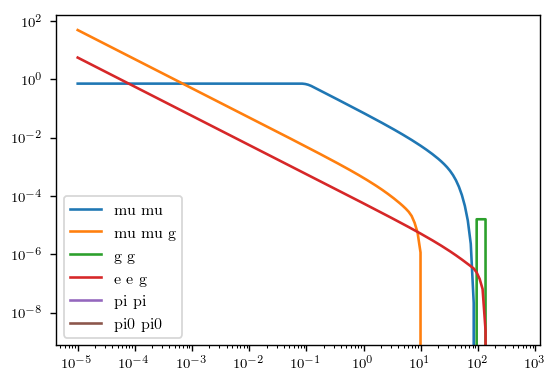

In [100]:
sm = HiggsPortal(225., 220., 1., 0.1)
e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw**2)

for fs in ["mu mu", "mu mu g", "g g", "e e g", "pi pi", "pi0 pi0"]:
    plt.loglog(e_gams, sm.dnde_ss(e_gams, e_cm, mode=fs), label=fs)

plt.legend()
# plt.ylim(1e-5, 1e-2)

## $m_\chi < m_S$

In [121]:
vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion

e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

mxs = np.array([100., 110., 140., 250.])
mM = 1e3
n_subplot_rows, n_subplot_cols = 2, len(mxs)

In [122]:
# Make array of models
sms = np.array([[HiggsPortal(mx, mM, gsxx=1., stheta=1e-1)
                 for mx in mxs],
                [HeavyQuark(mx, mM, gsxx=1., gsQ=1e-1, mQ=1e3, QQ=1.)
                 for mx in mxs]])
specs = []

for row in range(n_subplot_rows):
    specs_temp = []
    
    for col in range(n_subplot_cols):
        sm = sms[row, col]
        e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw**2)

        # Get individual channels' spectra
        spec_dict = {fs: spec for fs, spec in sm.spectra(e_gams, e_cm).iteritems()
                     if fs != "total"}
        # Computed total convolved spectrum
        dnde_det_fn = sm.get_detected_spectrum_function(e_gam_min, e_gam_max, e_cm,
                                                        energy_res=energy_res_comptel)
        spec_dict["total"] = dnde_det_fn(e_gams)
        specs_temp.append(spec_dict)

    specs.append(specs_temp)
    
specs = np.array(specs)

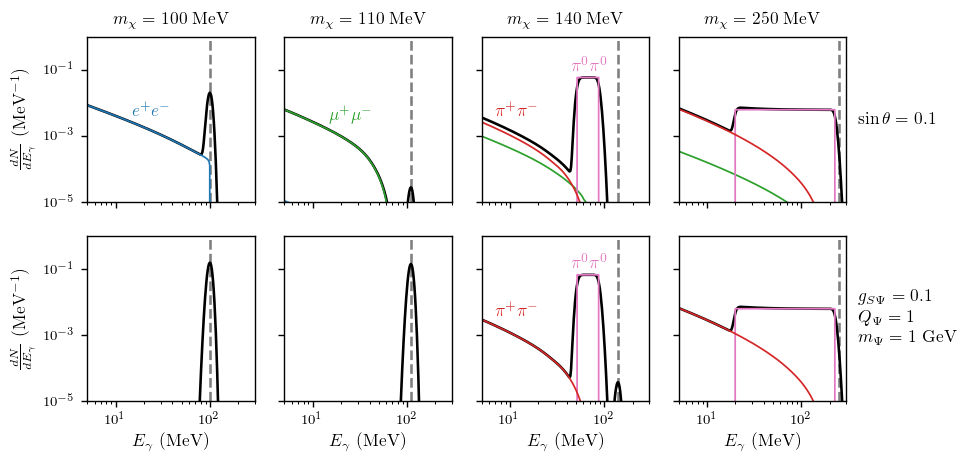

In [154]:
fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols,
                        sharex=True, sharey=True,
                        figsize=(latex_text_width_1col,
                                 0.55*latex_text_width_1col))

# Label final states
fs_labels = np.array([[{"e e": (1.5e1, 4e-3)},
                       {"mu mu": (1.5e1, 3e-3)},
                       {"pi pi": (7e0, 4e-3),
                        "pi0 pi0": (4.5e1, 9e-2)},
                       {}],
                      [{}, {},
                       {"pi pi": (7e0, 4e-3), "pi0 pi0": (4.5e1, 1.1e-1)},
                       {}]])

for row in range(n_subplot_rows):
    for col in range(n_subplot_cols):
        ax = axs[row, col]
        spec_dict = specs[row, col]
        sm = sms[row, col]
        e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw**2)

        # Plot total spectrum
        ax.loglog(e_gams, specs[row, col]["total"], 'k')
        
        # Compute line energies
        gamma_ray_lines = sm.gamma_ray_lines(e_cm)
        for fs, line_info in gamma_ray_lines.iteritems():
            ax.axvline(line_info["energy"], linestyle='--', color='k',
                       alpha=0.5, linewidth=1.5,
                       label=r"$E_{\gamma\gamma}$")

        # Plot spectra for each channel
        for fs in sm.list_annihilation_final_states():
            if fs not in gamma_ray_lines.keys() and fs != 'total':
                ax.loglog(e_gams, spec_dict[fs], linewidth=1,
                          color=get_color(fs), label=fs)

        # Label final states
        for fs, (x, y) in fs_labels[row, col].iteritems():
            ax.text(x, y, get_tex_label(fs), fontsize=10, color=get_color(fs))

for row in range(n_subplot_rows):
    axs[row, 0].set_ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
    axs[row, 0].set_ylim(1e-5, 1e0)

for col in range(n_subplot_cols):
    axs[0, col].set_title(r"$m_\chi = %i$ MeV" % mxs[col], fontsize=10)
    axs[-1, col].set_xlabel(r"$E_\gamma$ (MeV)")
    axs[-1, col].set_xlim(e_gam_min, e_gam_max)

# Label couplings
axs[0, -1].text(400, 3e-3, r"$\sin\theta = 0.1$", va="center", fontsize=10)
axs[1, -1].text(400, 3e-3,
                r"$g_{S\Psi} = 0.1$" + "\n" + r"$Q_\Psi = 1$" + "\n" + r"$m_\Psi = 1$ GeV",
                va="center", fontsize=10)

fig.tight_layout()
fig.savefig("figures/scalar_spectra.pdf", bbox_inches="tight")

## $m_\chi \geq m_S$

### Shared setup

In [103]:
vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion

e_gam_min, e_gam_max, n_e_gams = 5., 600., 100
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

mxs = np.array([[100., 200.], [300., 400.]])
mss = np.array([0.5, 150., 250., 350.])

n_subplot_rows, n_subplot_cols = mxs.shape

# Set up the colormap
# m = cm.ScalarMappable(norm=Normalize(vmin=0, vmax=len(mss)),
#                       cmap=cm.viridis_r)
# m.set_array(range(len(mss)))

In [77]:
def get_specs(get_sm):
    """Creates array of spectrum dictionaries.
    
    Args:
        sm: function returning a ScalarMediator with given DM and S mass
    """
    specs = []

    for mx_row in mxs:
        specs_temp = []

        for mx in mx_row:
            e_cm = 2.*mx * (1. + 0.5*vx_mw**2)

            # Computed total convolved spectrum for each value of ms/mx
            spec_dict = {}
            for ms in mss:
                # Only study annihilation into mediators
                if ms < mx:  # e_cm / 2:
                    sm = get_sm(mx, ms)
                    spec_dict[ms] = sm.dnde_ss(e_gams, e_cm)

            specs_temp.append(spec_dict)

        specs.append(specs_temp)

    return np.array(specs)

### Higgs portal

In [78]:
stheta = 0.1

specs_hp = get_specs(lambda mx, ms: HiggsPortal(mx, ms, 1., stheta))

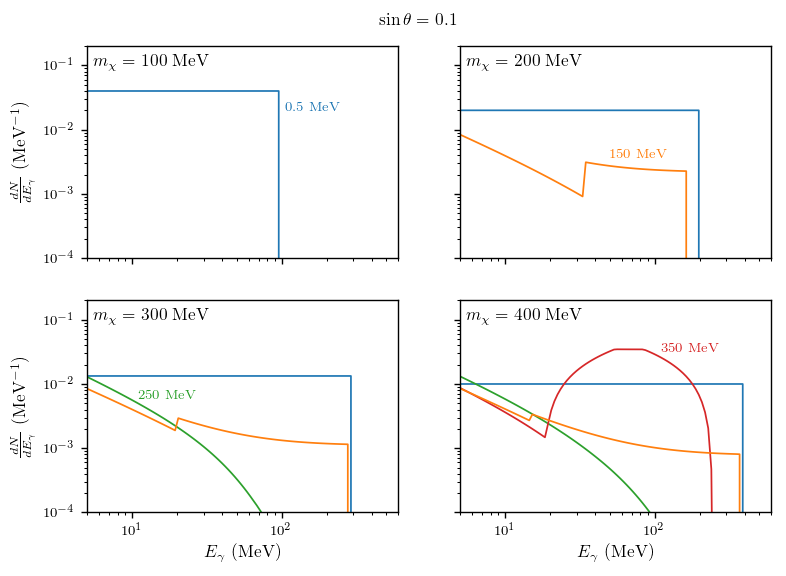

In [87]:
fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols,
                        sharex=True, sharey=True,
                        figsize=(latex_text_width_1col,
                                 0.7*latex_text_width_1col))

# Labels for spectra in each subplot
ms_label_poss = np.array([[{0.5: (1.05e2, 2e-2, "0.5 MeV")},
                           {150.: (5e1, 3.5e-3, "150 MeV")}],
                          [{250.: (1.1e1, 6e-3, "250 MeV")},
                           {350.: (1.1e2, 3.2e-2, "350 MeV")}]])

for row in range(n_subplot_rows):
    for col in range(n_subplot_cols):
        ax = axs[row, col]
        e_cm = 2.*mxs[row, col] * (1. + 0.5 * vx_mw**2)
        # Indicate DM mass
        axs[row, col].text(5.5, 9e-2, r"$m_\chi = %i$ MeV" % mxs[row, col],
                           fontsize=10)

        # Plot total spectrum
        for ms, spec in specs_hp[row, col].iteritems():
            color = colors[np.where(mss == ms)[0][0]]
            ax.loglog(e_gams, spec, color=color, linewidth=1)

        # Label most recently added spectra
        for ms, (x, y, label) in ms_label_poss[row, col].iteritems():
            color = colors[np.where(mss == ms)[0][0]]
            ax.text(x, y, label, color=color, fontsize=8)

for row in range(n_subplot_rows):
    axs[row, 0].set_ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
    axs[row, 0].set_ylim(1e-4, 2e-1)

for col in range(n_subplot_cols):
    axs[-1, col].set_xlabel(r"$E_\gamma$ (MeV)")
    axs[-1, col].set_xlim(e_gam_min, e_gam_max)

# Label couplings
fig.suptitle(r"$\sin\theta = %.1f$" % stheta, fontsize=10, y=0.935)

fig.savefig("figures/higgs_portal_spectra_ann_to_mediators.pdf",
            bbox_inches="tight")

### Heavy fermion

In [104]:
gsQ, mQ, QQ = 0.1, 1e3, 1.

specs_hq = get_specs(lambda mx, ms: HeavyQuark(mx, ms, 1., gsQ, mQ, QQ))

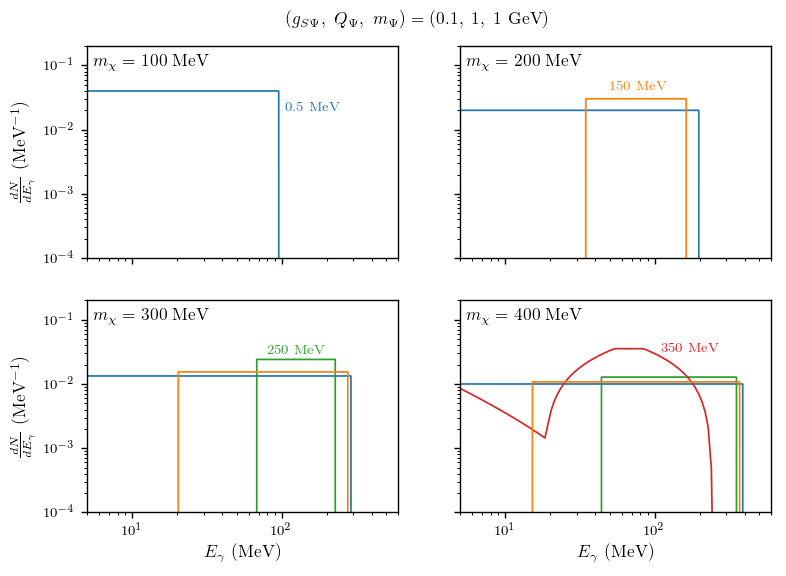

In [120]:
fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols,
                        sharex=True, sharey=True,
                        figsize=(latex_text_width_1col,
                                 0.7*latex_text_width_1col))

# Labels for spectra in each subplot
ms_label_poss = np.array([[{0.5: (1.05e2, 2e-2, "0.5 MeV")},
                           {150.: (5e1, 4e-2, "150 MeV")}],
                          [{250.: (8e1, 3e-2, "250 MeV")},
                           {350.: (1.1e2, 3.2e-2, "350 MeV")}]])

for row in range(n_subplot_rows):
    for col in range(n_subplot_cols):
        ax = axs[row, col]
        e_cm = 2.*mxs[row, col] * (1. + 0.5 * vx_mw**2)
        # Indicate DM mass
        axs[row, col].text(5.5, 9e-2, r"$m_\chi = %i$ MeV" % mxs[row, col],
                           fontsize=10)

        # Plot total spectrum
        for ms, spec in specs_hq[row, col].iteritems():
            color = colors[np.where(mss == ms)[0][0]]
            ax.loglog(e_gams, spec, color=color, linewidth=1)

        # Label most recently added spectra
        for ms, (x, y, label) in ms_label_poss[row, col].iteritems():
            color = colors[np.where(mss == ms)[0][0]]
            ax.text(x, y, label, color=color, fontsize=8)

for row in range(n_subplot_rows):
    axs[row, 0].set_ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
    axs[row, 0].set_ylim(1e-4, 2e-1)

for col in range(n_subplot_cols):
    axs[-1, col].set_xlabel(r"$E_\gamma$ (MeV)")
    axs[-1, col].set_xlim(e_gam_min, e_gam_max)

# Label couplings
fig.suptitle(r"$(g_{S\Psi},\ Q_\Psi,\ m_\Psi) = (%.1f,\ %i,\ %i~\mathrm{GeV})$" %
             (gsQ, QQ, mQ/1e3), fontsize=10, y=0.935)

fig.savefig("figures/heavy_fermion_spectra_ann_to_mediators.pdf",
            bbox_inches="tight")

### Combined

In [232]:
vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion

e_gam_min, e_gam_max, n_e_gams = 5., 600., 100
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

mxs = np.array([100., 200., 300., 400.])
n_subplot_rows, n_subplot_cols = 2, len(mxs)
# Values of ms
mss = np.array([1.,  50., 100., 150., 200., 250., 300., 400.])

# Set up the colormap
m = cm.ScalarMappable(norm=Normalize(vmin=mss[0], vmax=mss[-1]),
                      cmap=cm.viridis_r)
m.set_array(mss)

In [238]:
# Make array of models
sms = np.array([[HiggsPortal(mx, ms=1., gsxx=1., stheta=1e-1)
                 for mx in mxs],
                [HeavyQuark(mx, ms=1, gsxx=1., gsQ=1e-1, mQ=1e3, QQ=1.)
                 for mx in mxs]])
specs = []

for row in range(n_subplot_rows):
    specs_temp = []
    
    for col in range(n_subplot_cols):
        sm = sms[row, col]
        e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw**2)

        # Computed total convolved spectrum for each value of ms/mx
        spec_dict = {}
        for ms in mss:
            # Only study annihilation into mediators
            if ms < e_cm / 2:
                sm.ms = ms
                spec_dict[ms] = sm.dnde_ss(e_gams, e_cm)

                # Don't need to perform the convolution: s cannot produce
                # a gamma ray line
#                 dnde_det_fn = sm.get_detected_spectrum_function(
#                     e_gam_min, e_gam_max, e_cm, energy_res=energy_res_comptel)
#                 spec_dict[ms] = dnde_det_fn(e_gams)

        specs_temp.append(spec_dict)

    specs.append(specs_temp)
    
specs = np.array(specs)

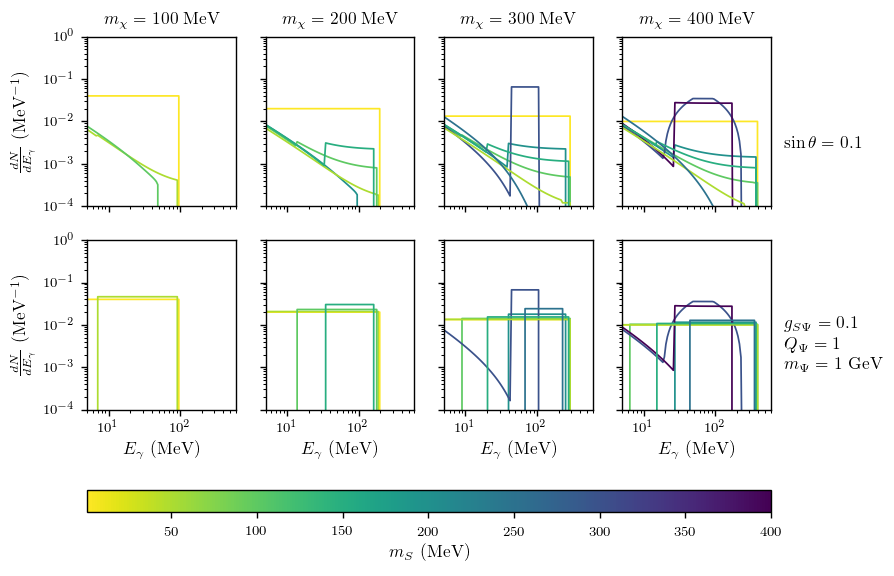

In [251]:
fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols,
                        sharex=True, sharey=True,
                        figsize=(latex_text_width_1col,
                                 0.8*latex_text_width_1col))

for row in range(n_subplot_rows):
    for col in range(n_subplot_cols):
        ax = axs[row, col]
        sm = sms[row, col]
        e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw**2)

        # Plot total spectrum
        for ms, spec in specs[row, col].iteritems():
            ax.loglog(e_gams, spec, color=m.to_rgba(ms), linewidth=1)

for row in range(n_subplot_rows):
    axs[row, 0].set_ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
    axs[row, 0].set_ylim(1e-4, 1e0)

for col in range(n_subplot_cols):
    axs[0, col].set_title(r"$m_\chi = %i$ MeV" % mxs[col], fontsize=10)
    axs[-1, col].set_xlabel(r"$E_\gamma$ (MeV)")
    axs[-1, col].set_xlim(e_gam_min, e_gam_max)

# Label couplings
axs[0, -1].text(900, 3e-3, r"$\sin\theta = 0.1$", va="center", fontsize=10)
axs[1, -1].text(900, 3e-3, r"$g_{S\Psi} = 0.1$" + "\n" + r"$Q_\Psi = 1$" +
                "\n" + r"$m_\Psi = 1$ GeV", va="center", fontsize=10)

# Format colorbar
cb = fig.colorbar(m, ax=axs.ravel().tolist(), orientation='horizontal',
                  aspect=30, pad=0.15)
cb.set_label(r"$m_S$ (MeV)")

fig.savefig("figures/scalar_spectra_ann_to_mediators.pdf", bbox_inches="tight")

# Old
4 panels

## Higgs portal couplings

Create a `ScalarMediator` object. The values of couplings to leptons and the strange quark and well as $m_S$ are irrelevant to our focus. The initial value of $m_\chi$ does not matter since it will shortly be changed. The velocity dispersion in the Milky Way $v_\chi \sim 10^{-3}$ is defined here and will be used to set the DM center of mass energy.

In [8]:
sm_args = {"mx": 250., "ms": 1000., "gsxx": 1.,
           "gsff": 1., "gsGG": 1., "gsFF": 1., "lam": vh}
sm = ScalarMediator(**sm_args)

vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion

Choose arrays of photon energies and DM masses. The DM mass array has the same shape as the array of subplots we want to generate.

In [9]:
e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

n_subplot_rows, n_subplot_cols = 2, 2
mxs = np.array([100., 110., 140., 250.]).reshape((n_subplot_rows, n_subplot_cols))

Iterate over the array of dark matter masses, computing the spectrum at each $E_\gamma \in$ `e_gams`. Most of the code below formats the plot nicely; the `spectra()` function is called in line 12.

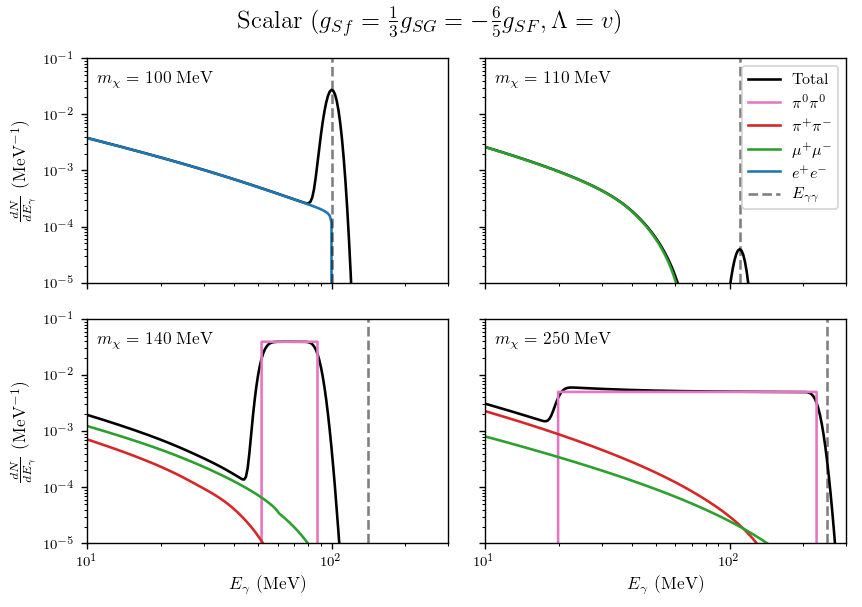

In [10]:
plt.figure(figsize=(latex_text_width_1col, 0.7*latex_text_width_1col))

# Iterate over the values, row and column indices of mxs
it = np.nditer(mxs, flags=['multi_index'])

while not it.finished:
    sm.mx = it[0]  # current value of mx
    idx = it.iterindex  # current index in mxs
    row_idx, col_idx = it.multi_index  # current row and column indices
    plt.subplot(n_subplot_rows, n_subplot_cols, idx + 1)
    
    # Center of mass energy, set to slightly above threshold
    e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw**2)

    # Plot total convolved spectrum
    dnde_det = sm.get_detected_spectrum(e_gam_min, e_gam_max,
                                        e_cm, energy_res=energy_res_comptel)
    plt.loglog(e_gams, dnde_det(e_gams), "black", label="Total")
    
    # Plot individual channels' spectra
    for fs, spec in reversed(sorted(sm.spectra(e_gams, e_cm).iteritems())):
        if fs not in ["total", "s s", "g g"]:
            plt.loglog(e_gams, spec, label=get_tex_label(fs),
                       color=get_color(fs),
                       linewidth=1.5)

    # Mark the lines' energies
    for ch, line in sm.gamma_ray_lines(e_cm).iteritems():
        plt.axvline(line["energy"], linestyle='--', color="k", alpha=0.5,
                    linewidth=1.5, label=r"$E_{\gamma\gamma}$")

    ### Formatting
    # Set axis limits
    plt.xlim(10, 300)
    plt.ylim(1e-5, 1e-1)

    # Only draw the legend for the first subplot
    if idx == 1:
        plt.legend(loc="best")
        
    # Only show ticks and axis labels for subplots on the left and bottom
    if row_idx != n_subplot_rows - 1:
        plt.tick_params(labelbottom="off")
    else:
        plt.xlabel(r"$E_\gamma$ (MeV)")
    if col_idx % n_subplot_cols != 0:
        plt.tick_params(labelleft="off")
    else:
        plt.ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
        
    # Label subplot with dark matter mass
    plt.text(1.1e1, 3.3e-2, r"$m_\chi = %0.f$ MeV" % sm.mx,
             fontsize=10)
    
    it.iternext()

# handles, labels = plt.gca().get_legend_handles_labels()
# lgd = plt.figlegend(handles, labels, loc="lower center",
#                     ncol=6, bbox_to_anchor=(0.5, -0.025))

plt.suptitle(r"Scalar ($g_{Sf} = \frac{1}{3} g_{SG} = -\frac{6}{5} g_{SF}, \Lambda = v$)")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # remove some of the space between plots
# plt.savefig("figures/scalar_spectra_higgs_portal.pdf")

## Heavy quark couplings

Create a `ScalarMediator` object. The values of couplings to leptons and the strange quark and well as $m_S$ are irrelevant to our focus. The initial value of $m_\chi$ does not matter since it will shortly be changed. The velocity dispersion in the Milky Way $v_\chi \sim 10^{-3}$ is defined here and will be used to set the DM center of mass energy.

In [21]:
sm_args = {"mx": 250., "ms": 1000., "gsxx": 1.,
           "gsff": 0., "gsGG": 1., "gsFF": 0.}
sm = ScalarMediator(**sm_args)

vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion

Choose arrays of photon energies and DM masses. The DM mass array has the same shape as the array of subplots we want to generate.

In [22]:
e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

n_subplot_rows, n_subplot_cols = 1, 2
mxs = np.array([140., 250.]).reshape((n_subplot_rows, n_subplot_cols))

Iterate over the array of dark matter masses, computing the spectrum at each $E_\gamma \in$ `e_gams`. Most of the code below formats the plot nicely; the `spectra()` function is called in line 12.

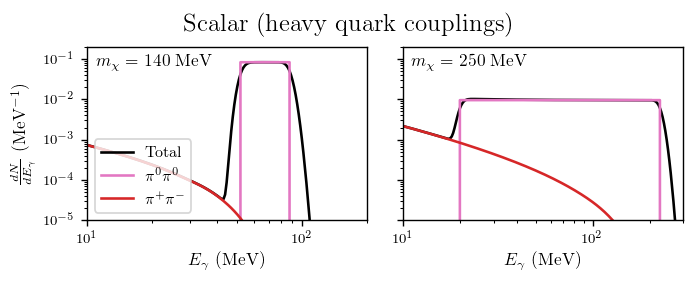

In [23]:
plt.figure(figsize=(latex_text_width_1col, 0.4*latex_text_width_1col))

# Iterate over the values, row and column indices of mxs
it = np.nditer(mxs, flags=['multi_index'])

while not it.finished:
    sm.mx = it[0]  # current value of mx
    idx = it.iterindex  # current index in mxs
    row_idx, col_idx = it.multi_index  # current row and column indices
    plt.subplot(n_subplot_rows, n_subplot_cols, idx + 1)
    
    # Center of mass energy, set to slightly above threshold
    e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw**2)

    # Plot total convolved spectrum
    dnde_det = sm.get_detected_spectrum(e_gam_min, e_gam_max,
                                        e_cm, energy_res=energy_res_comptel)
    plt.loglog(e_gams, dnde_det(e_gams), "black", label="Total")
    
    # Plot individual channels' spectra
    for fs, spec in reversed(sorted(sm.spectra(e_gams, e_cm).iteritems())):
        if fs not in ["total", "s s", "g g", "e e", "mu mu"]:
            plt.loglog(e_gams, spec, label=get_tex_label(fs),
                       color=get_color(fs),
                       linewidth=1.5)

    ### Formatting
    # Set axis limits
    if idx == 0:
        plt.xlim(10, 200)
    else:
        plt.xlim(10, 300)
        
    plt.ylim(1e-5, 2e-1)

    # Only draw the legend for the first subplot
    if idx == 0:
        plt.legend(loc="lower left")
        
    # Only show ticks and axis labels for subplots on the left and bottom
    if row_idx != n_subplot_rows - 1:
        plt.tick_params(labelbottom="off")
    else:
        plt.xlabel(r"$E_\gamma$ (MeV)")
    if col_idx % n_subplot_cols != 0:
        plt.tick_params(labelleft="off")
    else:
        plt.ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
        
    # Label subplot with dark matter mass
    plt.text(1.1e1, 6e-2, r"$m_\chi = %0.f$ MeV" % sm.mx,
             fontsize=10)
    
    it.iternext()

# handles, labels = plt.gca().get_legend_handles_labels()
# lgd = plt.figlegend(handles, labels, loc="lower center",
#                     ncol=6, bbox_to_anchor=(0.5, -0.025))

plt.suptitle(r"Scalar (heavy quark couplings)")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # remove some of the space between plots
plt.savefig("figures/scalar_spectra_heavy_quark.pdf")

## Dependence on couplings

In [8]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [9]:
sm_args = {"mx": 250., "ms": 1000., "gsxx": 1., "gsff": 1., "gsGG": 1., "gsFF": 1.}
sm = ScalarMediator(**sm_args)

vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion

In [10]:
e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

In [11]:
n_subplot_rows, n_subplot_cols = 2, 2
mxs = np.array([100., 110., 140., 250.]).reshape((n_subplot_rows, n_subplot_cols))

ratios = np.array([-1.5, 1000.])

In [12]:
# Set up the colormap
cmap = cm.viridis_r
norm = Normalize(vmin=ratios[0], vmax=ratios[-1])
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array(ratios)

In [13]:
# Compute the spectra!
spectra_det_sm = {}

for mx in mxs.flatten():
    sm.mx = mx  # current value of mx
    # Center of mass energy, set to slightly above threshold
    e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw**2)
    
    for ratio in ratios:
        sm.gsGG = ratio * sm.gsff
        spec = sm.spectra(e_gams, e_cm)["total"]
        spectra_det_sm[(mx, ratio)] = spec
#         dnde_det = get_detected_spectrum(e_gams, spec,
#                                          *sm.gamma_ray_lines(e_cm),
#                                          energy_res=energy_res_comptel)

#         spectra_det[(mx, ratio)] = dnde_det(e_gams)

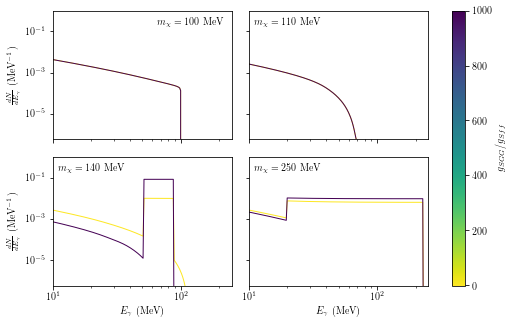

In [14]:
fig, axes = plt.subplots(nrows=n_subplot_rows, ncols=n_subplot_cols, figsize=(7.5, 5), sharex=True, sharey=True)

# Iterate over the values, row and column indices of mxs
it = np.nditer(mxs, flags=['multi_index'])

while not it.finished:
    idx = it.iterindex  # current index in mxs
    row_idx, col_idx = it.multi_index  # current row and column indices
    ax = axes[row_idx, col_idx]
    
    for ratio in ratios:
        ax.loglog(e_gams, spectra_det_sm[(float(it[0]), ratio)], color=m.to_rgba(ratio), linewidth=1)
    
    ### Formatting
    # Set axis limits
    plt.xlim(10, 250)
    plt.ylim(6e-7, 1e0)

    # Only show ticks and axis labels for subplots on the left and bottom
    if row_idx != n_subplot_rows - 1:
        ax.tick_params(labelbottom="off")
    else:
        ax.set_xlabel(r"$E_\gamma$ (MeV)")
    if col_idx % n_subplot_cols != 0:
        ax.tick_params(labelleft="off")
    else:
        ax.set_ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
        
    # Label subplot with dark matter mass
    if (row_idx, col_idx) == (0, 0):
        ax.text(6.5e1, 2e-1, r"$m_\chi = %0.f$ MeV" % it[0])
    else:
        ax.text(1.1e1, 2e-1, r"$m_\chi = %0.f$ MeV" % it[0])
    
    it.iternext()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # remove some of the space between plots
# plt.suptitle(r"Vector mediator")

fig.colorbar(m, ax=axes.ravel().tolist()).set_label(r"$g_{SGG} / g_{Sff}$")

# plt.savefig("figures/scalar_spectra_coupling_dependence.pdf")

## Scratch

In [4]:
from hazma.gamma_ray_parameters import (gc_bg_model, gc_target,
                                        comptel_diffuse, egret_diffuse,
                                        fermi_diffuse)
colors = [c["color"] for c in list(plt.rcParams["axes.prop_cycle"])]

### Binned limit diagram

In [35]:
sm_args = {"mx": 175., "ms": 1000., "gsxx": 1.,
           "gsff": 1., "gsGG": 1., "gsFF": 1.}
sm = ScalarMediator(**sm_args)

vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion
e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw**2)

e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

In [36]:
observations = [comptel_diffuse, egret_diffuse, fermi_diffuse]
coeffs = []
dnde_dets = []

for obs in observations:
    sv_lim_binned = sm.binned_limit(obs)
    coeffs.append(sv_lim_binned / (4*np.pi*2*2*sm.mx**2) * obs.target.J)#*obs.target.dOmega)
        
    dnde_dets.append(sm.get_detected_spectrum(e_gam_min, e_gam_max,
                                              e_cm, energy_res=obs.energy_res))

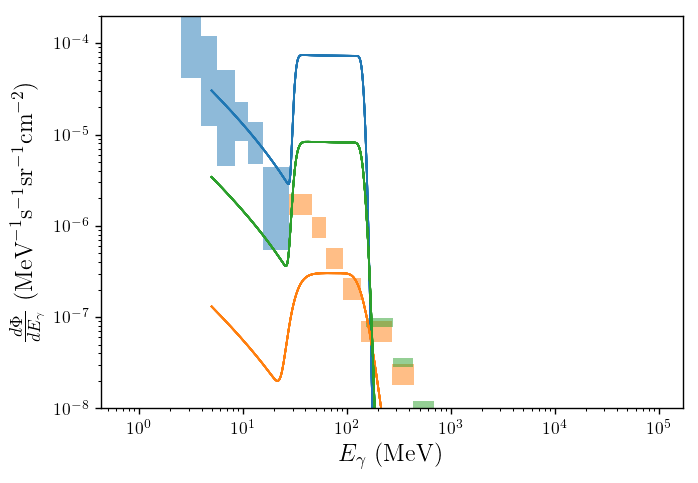

In [85]:
plt.figure(figsize=(latex_text_width_1col, 0.7*latex_text_width_1col))
power = 0

for c, coeff, dnde_det, obs in zip(colors, coeffs, dnde_dets, observations):
    for b, phi, low, high in zip(obs.bins, obs.fluxes,
                                 obs.lower_errors,
                                 obs.upper_errors):
        center = np.mean(b)
        plt.fill_between(b,
                         2*[center**power * (phi - 2*low)],
                         2*[center**power * (phi + 2*high)],
                         color=c, alpha=0.5, linewidth=0)
        
        plt.plot(e_gams,
                 e_gams**power * dnde_det(e_gams)*coeff,
                 color=c, linewidth=1)

# plt.xlim(5e0, 4e2)
plt.tick_params(axis='both', labelsize=10)
plt.ylim(1e-8, 2e-4)
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$\frac{d\Phi}{dE_\gamma}$ ($\mathrm{MeV}^{-1}\mathrm{s}^{-1}\mathrm{sr}^{-1}\mathrm{cm}^{-2}$)", fontsize=14)
plt.xlabel(r"$E_\gamma$ (MeV)", fontsize=14)

plt.tight_layout()
# plt.savefig("/Users/acoogan/Dropbox/Physics/Thesis/figures/hazma_figures/binned_lim.pdf")

### Unbinned limit diagram

In [51]:
sm_args = {"mx": 140., "ms": 1000., "gsxx": 1.,
           "gsff": 1., "gsGG": 1., "gsFF": 1.}
sm = ScalarMediator(**sm_args)

vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion
e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw**2)

e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

In [52]:
sv_lim_unbinned = sm.unbinned_limit(target_params=gc_target,
                           bg_model=gc_bg_model,
                           debug_msgs=True)

coeff = sv_lim_unbinned * gc_target.J / (4*np.pi*2*2*sm.mx**2)  # * gc_target.dOmega

	e_a, e_b =  [ 49.87775545 105.52484793]


/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:233: RuntimeWarning: invalid value encountered in sqrt
  df_de_a = 1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:235: RuntimeWarning: invalid value encountered in sqrt
  df_de_b = -1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:239: RuntimeWarning: invalid value encountered in sqrt
  return -I_S_val/np.sqrt(I_B_val), jac_val


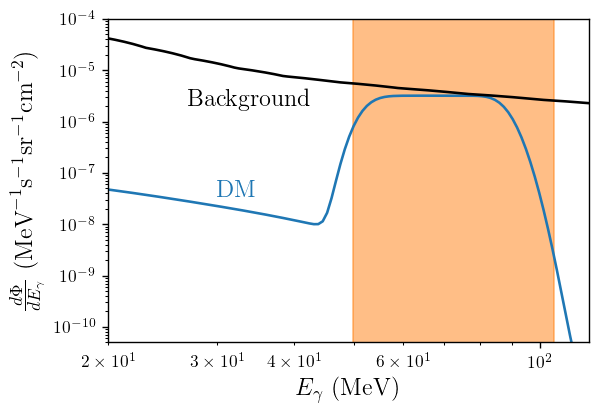

In [59]:
dnde_det = sm.get_detected_spectrum(e_gam_min, e_gam_max,
                                    e_cm, energy_res=energy_res_comptel)
plt.loglog(e_gams, coeff*dnde_det(e_gams))

plt.fill_betweenx([1e-20, 1e5], 49.88, 105.52,
                  alpha=0.5,
                  color=list(plt.rcParams["axes.prop_cycle"])[1]["color"])

plt.loglog(e_gams, gc_bg_model.dPhi_dEdOmega(e_gams), 'k')

plt.text(2.7e1, 2e-6, "Background", fontsize=14)
plt.text(3e1, 3.3e-10, r"DM", color=colors[0], fontsize=14)

plt.xlim(20, 120)
plt.ylim(5e-11, 1e-4)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.ylabel(r"$\frac{d\Phi}{dE_\gamma}$ ($\mathrm{MeV}^{-1}\mathrm{s}^{-1}\mathrm{sr}^{-1}\mathrm{cm}^{-2}$)", fontsize=14)
plt.xlabel(r"$E_\gamma$ (MeV)", fontsize=14)
###
plt.tight_layout()  # remove some of the space between plots
plt.savefig("/Users/acoogan/Dropbox/Physics/Thesis/figures/hazma_figures/unbinned_lim_normed.pdf")

In [37]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [57]:
dm_interp = interp1d(e_gams, coeff*dnde_det(e_gams))

quad(dm_interp, 49.88, 105.52)[0] / \
    np.sqrt(quad(gc_bg_model.dPhi_dEdOmega, 49.88, 105.52)[0]) * \
    np.sqrt(1e3 * 24.*365*60*60 * gc_target.dOmega)

5.121165356977719